In [1]:
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
exp_folder = 'RNN_MD'
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from tqdm.notebook import tqdm, trange

'''
source activate pytorch
cd tmp
nohup python -u default_test_twotasks.py > default_test_twotasks.log 2>&1 &

# Turn off MD by changing config, file name of log & perf
'''


###--------------------------Training configs--------------------------###

# set device
device = 'cuda' # always CPU


Config

In [60]:
# set config
config = {
    # envs
     'tasks': ['yang19.dlygo-v0',
             'yang19.rtgo-v0',
               
               'yang19.dlyanti-v0',
               'yang19.go-v0',
               'yang19.dms-v0',
               'yang19.dnms-v0',
               'yang19.dmc-v0',
               'yang19.dnmc-v0',
#                'yang19.dm1-v0',
#                'yang19.dm2-v0',
#                'yang19.ctxdm1-v0',
#                'yang19.ctxdm2-v0',
#                'yang19.multidm-v0',
               'yang19.anti-v0',
#                'yang19.rtgo-v0',
               'yang19.rtanti-v0'
              ],
     'env_kwargs': {'dt': 100},
     'seq_len': 50,
    # Training
    'use_lstm': False,
     'trials_per_task' : 200000,
     'batch_size' : 100,
     'print_every_batches': 100,
    # model
     'input_size': 33,
     'hidden_size': 256,
     'sub_size': 128,
     'output_size': 17,
     'num_task': 2,
     'MDeffect': False,
     'md_size': 10,
     'md_active_size': 5,
     'md_dt': 0.001,
    # optimizer
     'lr': 1e-4, # 1e-4 for CTRNN, 1e-3 for LSTM
}
config.update({'human_task_names': ['{:<6}'.format(tn[7:-3]) for tn in config['tasks']]})

task_seq = []
task_sub_seqs = [[(i, config['tasks'][i]) for i in range(s)] for s in range(2, len(config['tasks']))] # interleave tasks and add one task at a time
for sub_seq in task_sub_seqs: task_seq+=sub_seq

simplified_task_seq = [(i, config['tasks'][i]) for i in range(len(config['tasks']))]
task_seq = simplified_task_seq
print('Task seq to be learned: ', task_seq)


Task seq to be learned:  [(0, 'yang19.dlygo-v0'), (1, 'yang19.rtgo-v0'), (2, 'yang19.dlyanti-v0'), (3, 'yang19.go-v0'), (4, 'yang19.dms-v0'), (5, 'yang19.dnms-v0'), (6, 'yang19.dmc-v0'), (7, 'yang19.dnmc-v0'), (8, 'yang19.anti-v0'), (9, 'yang19.rtanti-v0')]


In [61]:
def get_performance(net, envs, context_ids, batch_size=100, device='cpu'):
    if type(envs) is not type([]):
        envs = [envs]

    fixation_accuracies = defaultdict()
    action_accuracies = defaultdict()
    for task_i, (context_id, env) in enumerate(zip(context_ids, envs)):

        inputs, labels = get_trials_batch(env, batch_size)
        if config['use_lstm']:
            action_pred, _ = net(inputs) # shape [500, 10, 17]
        else:
            action_pred, _ = net(inputs, sub_id=context_id) # shape [500, 10, 17]
        ap = torch.argmax(action_pred, -1) # shape ap [500, 10]

        gt = torch.argmax(labels, -1)

        fix_lens = torch.sum(gt==0, 0)
        act_lens = gt.shape[0] - fix_lens 

        fixation_accuracy = ((gt==0)==(ap==0)).sum() / np.prod(gt.shape)## get fixation performance. overlap between when gt is to fixate and when model is fixating
           ## then divide by number of time steps.
        fixation_accuracies[task_i] = fixation_accuracy.detach().cpu().numpy()
        action_accuracy = (gt[-1,:] == ap[ -1,:]).sum() / gt.shape[1] # take action as the argmax of the last time step
        action_accuracies[task_i] = action_accuracy.detach().cpu().numpy()
#         import pdb; pdb.set_trace()
    return((fixation_accuracies, action_accuracies))

In [62]:
def create_log (task_i, task_id, task_name):
    return     ({
        'task_i': task_i,
        'task_id': task_id,
        'task_name' : task_name,
        'stamps': [],
        'losses': [],
        'gradients': [],
        'accuracy' : [],
        'fixation_accuracy': [],
    })

In [63]:
def accuracy_metric(outputs, labels):
    ap = torch.argmax(outputs, -1) # shape ap [500, 10]
    gt = torch.argmax(labels, -1)
    action_accuracy = (gt[-1, :] == ap[-1,:]).sum() / gt.shape[1] # take action as the argmax of the last time step
#     import pdb; pdb.set_trace()
    return(action_accuracy.detach().cpu().numpy())


In [64]:
def get_trials_batch(envs, batch_size):
    # check if only one env or several and ensure it is a list either way.
    if type(envs) is not type([]):
        envs = [envs]
        
    # fetch and batch data
    obs, gts = [], []
    for bi in range(batch_size):
        env = envs[np.random.randint(0, len(envs))] # randomly choose one env to sample from, if more than one env is given
        env.new_trial()
        ob, gt = env.ob, env.gt
        assert not np.any(np.isnan(ob))
        obs.append(ob), gts.append(gt)
    # Make trials of equal time length:
    obs_lens = [len(o) for o in obs]
    max_len = np.max(obs_lens)
    for o in range(len(obs)):
        while len(obs[o]) < max_len:
            obs[o]= np.insert(obs[o], 0, obs[o][0], axis=0)
#             import pdb; pdb.set_trace()
    gts_lens = [len(o) for o in gts]
    max_len = np.max(gts_lens)
    for o in range(len(gts)):
        while len(gts[o]) < max_len:
            gts[o]= np.insert(gts[o], 0, gts[o][0], axis=0)


    obs = np.stack(obs) # shape (batch_size, 32, 33)
    
    gts = np.stack(gts) # shape (batch_size, 32)

    # numpy -> torch
    inputs = torch.from_numpy(obs).type(torch.float).to(device)
    labels = torch.from_numpy(gts).type(torch.long).to(device)

    # index -> one-hot vector
    labels = (F.one_hot(labels, num_classes=config['output_size'])).float() 
    return (inputs.permute([1,0,2]), labels.permute([1,0,2])) # using time first [time, batch, input]


In [65]:
# main loop
envs = []
num_tasks = len(config['tasks'])
# Make all tasks
for task_id in range(num_tasks):
    env = gym.make(config['tasks'][task_id], **config['env_kwargs'])
    envs.append(env)
training_logs = []
testing_logs = []
bar_tasks = enumerate(tqdm(task_seq))
for task_i, (task_id, task_name) in bar_tasks:
  
    env = envs[task_id]
    tqdm.write('learning task:\t ' + config['human_task_names'][task_id])

    # model
    if config['use_lstm']:
        from model_dev import Net
        net = Net(input_size     = config['input_size'],
                 hidden_size    = config['hidden_size'],
                 output_size    = config['output_size'],)
    else:
        net = RNN_MD(input_size     = config['input_size'],
                 hidden_size    = config['hidden_size'],
                 sub_size       = config['sub_size'],
                 output_size    = config['output_size'],
                 num_task       = config['num_task'],
                 dt             = config['env_kwargs']['dt'],
                 MDeffect       = config['MDeffect'],
                 md_size        = config['md_size'],
                 md_active_size = config['md_active_size'],
                 md_dt          = config['md_dt'],)
    net = net.to(device)

    # criterion & optimizer
    criterion = nn.MSELoss()
    print('training parameters:')
    training_params = list()
    for name, param in net.named_parameters():
        print(name)
        training_params.append(param)
    optimizer = torch.optim.Adam(training_params, lr=config['lr'])

    # training
    training_log = create_log(task_i,task_id, task_name,)
    testing_log = create_log(task_i,task_id, task_name,)
    
    if config['MDeffect']:
        net.rnn.md.learn = True
        net.rnn.md.sendinputs = True
    
    training_bar = trange(config['trials_per_task']//config['batch_size'])
    for i in training_bar:
        # control training paradigm
        context_id = 0

        # fetch data
        inputs, labels = get_trials_batch(envs=env, batch_size = config['batch_size'])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        if config['use_lstm']:
            outputs, rnn_activity = net(inputs)
        else:
            outputs, rnn_activity = net(inputs, sub_id=context_id)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc  = accuracy_metric(outputs.detach(), labels.detach())

        # save loss
        training_log['losses'].append(loss.item())
        training_log['stamps'].append(i)
        training_log['accuracy'].append(acc)
        
        training_bar.set_description('loss, acc: {:0.4F}, {:0.3F}'.format(loss.item(), acc))
#         training_bar.set_description('loss, acc: {:0.3F}, {0.3F}'.format(loss.item(), acc))

        # print statistics
        if i % config['print_every_batches'] == (config['print_every_batches'] - 1):
            ################################ test during training
            net.eval()
            if config['MDeffect']:
                net.rnn.md.learn = False
            with torch.no_grad():
                testing_log['stamps'].append(i+1)
                #   fixation & action performance
                print('Performance')
                num_tasks = len(config['tasks'])
                
                fix_perf, act_perf = get_performance(
                    net,
                    envs,
                    context_ids=[context_id]*len(envs),
                    device=device) 
                
                testing_log['fixation_accuracy'].append(fix_perf)
                testing_log['accuracy'].append(act_perf)

                for env_id in range(num_tasks):
                    print('  act performance, task #, name {:d} {}, batch# {:d}: {:0.2f}'.format(
                        env_id+1, config['human_task_names'][env_id], i+1,
                        act_perf[env_id]))
            net.train()
            if config['MDeffect']:
                net.rnn.md.learn = True
    training_log['sample_input'] = inputs[0].detach().cpu().numpy().T
    training_log['sample_label'] = labels[0].detach().cpu().numpy().T
    training_log['sample_output'] = outputs[0].detach().cpu().numpy().T
    training_logs.append(training_log)
    testing_logs.append(testing_log)

  0%|          | 0/10 [00:00<?, ?it/s]

learning task:	 dlygo 
training parameters:
rnn.input2h.weight
rnn.input2h.bias
rnn.h2h.weight
rnn.h2h.bias
fc.weight
fc.bias


  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.43
  act performance, task #, name 6 dnms  , batch# 100: 0.57
  act performance, task #, name 7 dmc   , batch# 100: 0.51
  act performance, task #, name 8 dnmc  , batch# 100: 0.50
  act performance, task #, name 9 anti  , batch# 100: 0.00
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.03
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.04
  act performance, task #, name 4 go    , batch# 200: 0.12
  act performance, task #, name 5 dms   , batch# 200: 0.01
  act performance, task #, name 6 dnms  , batch# 200: 0.06
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.81
  act performance, task #, name 2 rtgo  , batch# 1500: 0.00
  act performance, task #, name 3 dlyanti, batch# 1500: 0.00
  act performance, task #, name 4 go    , batch# 1500: 0.29
  act performance, task #, name 5 dms   , batch# 1500: 0.08
  act performance, task #, name 6 dnms  , batch# 1500: 0.18
  act performance, task #, name 7 dmc   , batch# 1500: 0.19
  act performance, task #, name 8 dnmc  , batch# 1500: 0.12
  act performance, task #, name 9 anti  , batch# 1500: 0.16
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.78
  act performance, task #, name 2 rtgo  , batch# 1600: 0.02
  act performance, task #, name 3 dlyanti, batch# 1600: 0.00
  act performance, task #, name 4 go    , batch# 1600: 0.43
  act performance, task #, name 5 dms   , batch# 1600: 0.20
  act performance, task #, name 6 dnms  , batch# 1600: 0.14
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.02
  act performance, task #, name 2 rtgo  , batch# 100: 0.76
  act performance, task #, name 3 dlyanti, batch# 100: 0.09
  act performance, task #, name 4 go    , batch# 100: 0.19
  act performance, task #, name 5 dms   , batch# 100: 0.02
  act performance, task #, name 6 dnms  , batch# 100: 0.04
  act performance, task #, name 7 dmc   , batch# 100: 0.04
  act performance, task #, name 8 dnmc  , batch# 100: 0.01
  act performance, task #, name 9 anti  , batch# 100: 0.03
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.09
  act performance, task #, name 2 rtgo  , batch# 200: 1.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.05
  act performance, task #, name 4 go    , batch# 200: 0.30
  act performance, task #, name 5 dms   , batch# 200: 0.49
  act performance, task #, name 6 dnms  , batch# 200: 0.52
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.00
  act performance, task #, name 2 rtgo  , batch# 1500: 1.00
  act performance, task #, name 3 dlyanti, batch# 1500: 0.00
  act performance, task #, name 4 go    , batch# 1500: 0.20
  act performance, task #, name 5 dms   , batch# 1500: 0.54
  act performance, task #, name 6 dnms  , batch# 1500: 0.46
  act performance, task #, name 7 dmc   , batch# 1500: 0.52
  act performance, task #, name 8 dnmc  , batch# 1500: 0.47
  act performance, task #, name 9 anti  , batch# 1500: 0.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.00
  act performance, task #, name 2 rtgo  , batch# 1600: 1.00
  act performance, task #, name 3 dlyanti, batch# 1600: 0.00
  act performance, task #, name 4 go    , batch# 1600: 0.10
  act performance, task #, name 5 dms   , batch# 1600: 0.43
  act performance, task #, name 6 dnms  , batch# 1600: 0.55
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.44
  act performance, task #, name 6 dnms  , batch# 100: 0.55
  act performance, task #, name 7 dmc   , batch# 100: 0.51
  act performance, task #, name 8 dnmc  , batch# 100: 0.46
  act performance, task #, name 9 anti  , batch# 100: 0.00
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.09
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.06
  act performance, task #, name 4 go    , batch# 200: 0.00
  act performance, task #, name 5 dms   , batch# 200: 0.03
  act performance, task #, name 6 dnms  , batch# 200: 0.02
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.00
  act performance, task #, name 2 rtgo  , batch# 1500: 0.00
  act performance, task #, name 3 dlyanti, batch# 1500: 0.67
  act performance, task #, name 4 go    , batch# 1500: 0.00
  act performance, task #, name 5 dms   , batch# 1500: 0.13
  act performance, task #, name 6 dnms  , batch# 1500: 0.11
  act performance, task #, name 7 dmc   , batch# 1500: 0.09
  act performance, task #, name 8 dnmc  , batch# 1500: 0.15
  act performance, task #, name 9 anti  , batch# 1500: 0.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.00
  act performance, task #, name 2 rtgo  , batch# 1600: 0.00
  act performance, task #, name 3 dlyanti, batch# 1600: 0.63
  act performance, task #, name 4 go    , batch# 1600: 0.00
  act performance, task #, name 5 dms   , batch# 1600: 0.09
  act performance, task #, name 6 dnms  , batch# 1600: 0.09
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.54
  act performance, task #, name 6 dnms  , batch# 100: 0.48
  act performance, task #, name 7 dmc   , batch# 100: 0.55
  act performance, task #, name 8 dnmc  , batch# 100: 0.44
  act performance, task #, name 9 anti  , batch# 100: 0.00
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.07
  act performance, task #, name 2 rtgo  , batch# 200: 0.46
  act performance, task #, name 3 dlyanti, batch# 200: 0.07
  act performance, task #, name 4 go    , batch# 200: 0.45
  act performance, task #, name 5 dms   , batch# 200: 0.48
  act performance, task #, name 6 dnms  , batch# 200: 0.56
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 1.00
  act performance, task #, name 2 rtgo  , batch# 1500: 0.78
  act performance, task #, name 3 dlyanti, batch# 1500: 0.00
  act performance, task #, name 4 go    , batch# 1500: 1.00
  act performance, task #, name 5 dms   , batch# 1500: 0.38
  act performance, task #, name 6 dnms  , batch# 1500: 0.08
  act performance, task #, name 7 dmc   , batch# 1500: 0.13
  act performance, task #, name 8 dnmc  , batch# 1500: 0.06
  act performance, task #, name 9 anti  , batch# 1500: 0.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 1.00
  act performance, task #, name 2 rtgo  , batch# 1600: 0.73
  act performance, task #, name 3 dlyanti, batch# 1600: 0.00
  act performance, task #, name 4 go    , batch# 1600: 1.00
  act performance, task #, name 5 dms   , batch# 1600: 0.37
  act performance, task #, name 6 dnms  , batch# 1600: 0.05
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.55
  act performance, task #, name 6 dnms  , batch# 100: 0.47
  act performance, task #, name 7 dmc   , batch# 100: 0.44
  act performance, task #, name 8 dnmc  , batch# 100: 0.47
  act performance, task #, name 9 anti  , batch# 100: 0.00
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.00
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.00
  act performance, task #, name 4 go    , batch# 200: 0.00
  act performance, task #, name 5 dms   , batch# 200: 0.43
  act performance, task #, name 6 dnms  , batch# 200: 0.48
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.00
  act performance, task #, name 2 rtgo  , batch# 1500: 0.00
  act performance, task #, name 3 dlyanti, batch# 1500: 0.00
  act performance, task #, name 4 go    , batch# 1500: 0.00
  act performance, task #, name 5 dms   , batch# 1500: 1.00
  act performance, task #, name 6 dnms  , batch# 1500: 0.00
  act performance, task #, name 7 dmc   , batch# 1500: 0.77
  act performance, task #, name 8 dnmc  , batch# 1500: 0.16
  act performance, task #, name 9 anti  , batch# 1500: 0.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.00
  act performance, task #, name 2 rtgo  , batch# 1600: 0.00
  act performance, task #, name 3 dlyanti, batch# 1600: 0.00
  act performance, task #, name 4 go    , batch# 1600: 0.00
  act performance, task #, name 5 dms   , batch# 1600: 1.00
  act performance, task #, name 6 dnms  , batch# 1600: 0.00
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.54
  act performance, task #, name 6 dnms  , batch# 100: 0.61
  act performance, task #, name 7 dmc   , batch# 100: 0.48
  act performance, task #, name 8 dnmc  , batch# 100: 0.56
  act performance, task #, name 9 anti  , batch# 100: 0.00
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.00
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.00
  act performance, task #, name 4 go    , batch# 200: 0.00
  act performance, task #, name 5 dms   , batch# 200: 0.42
  act performance, task #, name 6 dnms  , batch# 200: 0.48
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.02
  act performance, task #, name 2 rtgo  , batch# 1500: 0.02
  act performance, task #, name 3 dlyanti, batch# 1500: 0.00
  act performance, task #, name 4 go    , batch# 1500: 0.04
  act performance, task #, name 5 dms   , batch# 1500: 0.00
  act performance, task #, name 6 dnms  , batch# 1500: 1.00
  act performance, task #, name 7 dmc   , batch# 1500: 0.25
  act performance, task #, name 8 dnmc  , batch# 1500: 0.82
  act performance, task #, name 9 anti  , batch# 1500: 0.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.00
  act performance, task #, name 2 rtgo  , batch# 1600: 0.04
  act performance, task #, name 3 dlyanti, batch# 1600: 0.00
  act performance, task #, name 4 go    , batch# 1600: 0.04
  act performance, task #, name 5 dms   , batch# 1600: 0.00
  act performance, task #, name 6 dnms  , batch# 1600: 1.00
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.43
  act performance, task #, name 6 dnms  , batch# 100: 0.50
  act performance, task #, name 7 dmc   , batch# 100: 0.49
  act performance, task #, name 8 dnmc  , batch# 100: 0.52
  act performance, task #, name 9 anti  , batch# 100: 0.00
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.00
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.00
  act performance, task #, name 4 go    , batch# 200: 0.00
  act performance, task #, name 5 dms   , batch# 200: 0.52
  act performance, task #, name 6 dnms  , batch# 200: 0.52
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.00
  act performance, task #, name 2 rtgo  , batch# 1500: 0.00
  act performance, task #, name 3 dlyanti, batch# 1500: 0.00
  act performance, task #, name 4 go    , batch# 1500: 0.00
  act performance, task #, name 5 dms   , batch# 1500: 0.93
  act performance, task #, name 6 dnms  , batch# 1500: 0.08
  act performance, task #, name 7 dmc   , batch# 1500: 1.00
  act performance, task #, name 8 dnmc  , batch# 1500: 0.00
  act performance, task #, name 9 anti  , batch# 1500: 0.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.00
  act performance, task #, name 2 rtgo  , batch# 1600: 0.00
  act performance, task #, name 3 dlyanti, batch# 1600: 0.00
  act performance, task #, name 4 go    , batch# 1600: 0.00
  act performance, task #, name 5 dms   , batch# 1600: 0.95
  act performance, task #, name 6 dnms  , batch# 1600: 0.04
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.43
  act performance, task #, name 6 dnms  , batch# 100: 0.41
  act performance, task #, name 7 dmc   , batch# 100: 0.57
  act performance, task #, name 8 dnmc  , batch# 100: 0.52
  act performance, task #, name 9 anti  , batch# 100: 0.00
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.00
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.00
  act performance, task #, name 4 go    , batch# 200: 0.00
  act performance, task #, name 5 dms   , batch# 200: 0.54
  act performance, task #, name 6 dnms  , batch# 200: 0.43
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.00
  act performance, task #, name 2 rtgo  , batch# 1500: 0.00
  act performance, task #, name 3 dlyanti, batch# 1500: 0.00
  act performance, task #, name 4 go    , batch# 1500: 0.00
  act performance, task #, name 5 dms   , batch# 1500: 0.10
  act performance, task #, name 6 dnms  , batch# 1500: 0.84
  act performance, task #, name 7 dmc   , batch# 1500: 0.00
  act performance, task #, name 8 dnmc  , batch# 1500: 0.94
  act performance, task #, name 9 anti  , batch# 1500: 0.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.00
  act performance, task #, name 2 rtgo  , batch# 1600: 0.00
  act performance, task #, name 3 dlyanti, batch# 1600: 0.00
  act performance, task #, name 4 go    , batch# 1600: 0.00
  act performance, task #, name 5 dms   , batch# 1600: 0.05
  act performance, task #, name 6 dnms  , batch# 1600: 0.89
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.00
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.00
  act performance, task #, name 4 go    , batch# 100: 0.00
  act performance, task #, name 5 dms   , batch# 100: 0.45
  act performance, task #, name 6 dnms  , batch# 100: 0.46
  act performance, task #, name 7 dmc   , batch# 100: 0.49
  act performance, task #, name 8 dnmc  , batch# 100: 0.51
  act performance, task #, name 9 anti  , batch# 100: 0.05
  act performance, task #, name 10 rtanti, batch# 100: 0.00
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.02
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.15
  act performance, task #, name 4 go    , batch# 200: 0.00
  act performance, task #, name 5 dms   , batch# 200: 0.05
  act performance, task #, name 6 dnms  , batch# 200: 0.02
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.00
  act performance, task #, name 2 rtgo  , batch# 1500: 0.00
  act performance, task #, name 3 dlyanti, batch# 1500: 1.00
  act performance, task #, name 4 go    , batch# 1500: 0.00
  act performance, task #, name 5 dms   , batch# 1500: 0.02
  act performance, task #, name 6 dnms  , batch# 1500: 0.23
  act performance, task #, name 7 dmc   , batch# 1500: 0.03
  act performance, task #, name 8 dnmc  , batch# 1500: 0.02
  act performance, task #, name 9 anti  , batch# 1500: 1.00
  act performance, task #, name 10 rtanti, batch# 1500: 0.62
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.00
  act performance, task #, name 2 rtgo  , batch# 1600: 0.00
  act performance, task #, name 3 dlyanti, batch# 1600: 1.00
  act performance, task #, name 4 go    , batch# 1600: 0.00
  act performance, task #, name 5 dms   , batch# 1600: 0.01
  act performance, task #, name 6 dnms  , batch# 1600: 0.18
  act perform

  0%|          | 0/2000 [00:00<?, ?it/s]

Performance
  act performance, task #, name 1 dlygo , batch# 100: 0.08
  act performance, task #, name 2 rtgo  , batch# 100: 0.00
  act performance, task #, name 3 dlyanti, batch# 100: 0.05
  act performance, task #, name 4 go    , batch# 100: 0.08
  act performance, task #, name 5 dms   , batch# 100: 0.06
  act performance, task #, name 6 dnms  , batch# 100: 0.02
  act performance, task #, name 7 dmc   , batch# 100: 0.03
  act performance, task #, name 8 dnmc  , batch# 100: 0.03
  act performance, task #, name 9 anti  , batch# 100: 0.08
  act performance, task #, name 10 rtanti, batch# 100: 0.68
Performance
  act performance, task #, name 1 dlygo , batch# 200: 0.03
  act performance, task #, name 2 rtgo  , batch# 200: 0.00
  act performance, task #, name 3 dlyanti, batch# 200: 0.12
  act performance, task #, name 4 go    , batch# 200: 0.06
  act performance, task #, name 5 dms   , batch# 200: 0.40
  act performance, task #, name 6 dnms  , batch# 200: 0.50
  act performance, task #, na

Performance
  act performance, task #, name 1 dlygo , batch# 1500: 0.06
  act performance, task #, name 2 rtgo  , batch# 1500: 0.00
  act performance, task #, name 3 dlyanti, batch# 1500: 0.07
  act performance, task #, name 4 go    , batch# 1500: 0.00
  act performance, task #, name 5 dms   , batch# 1500: 0.03
  act performance, task #, name 6 dnms  , batch# 1500: 0.03
  act performance, task #, name 7 dmc   , batch# 1500: 0.01
  act performance, task #, name 8 dnmc  , batch# 1500: 0.05
  act performance, task #, name 9 anti  , batch# 1500: 0.42
  act performance, task #, name 10 rtanti, batch# 1500: 1.00
Performance
  act performance, task #, name 1 dlygo , batch# 1600: 0.03
  act performance, task #, name 2 rtgo  , batch# 1600: 0.00
  act performance, task #, name 3 dlyanti, batch# 1600: 0.05
  act performance, task #, name 4 go    , batch# 1600: 0.00
  act performance, task #, name 5 dms   , batch# 1600: 0.03
  act performance, task #, name 6 dnms  , batch# 1600: 0.03
  act perform

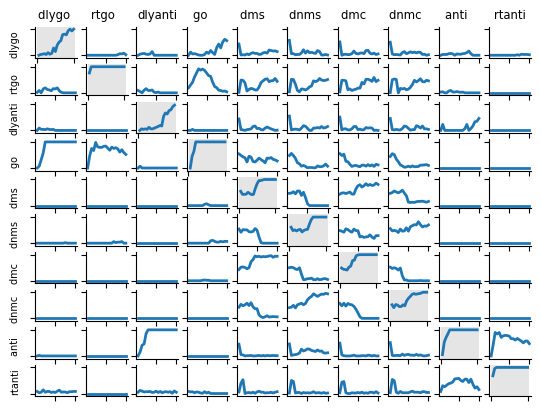

In [66]:
num_tasks = len(config['tasks'])
fig, axes = plt.subplots(num_tasks,num_tasks)
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[logi ,li ]
        ax.set_ylim([-0.1,1.1])
#         ax.axis('off')
        log = testing_logs[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        if logi == 0: ax.set_title(config['human_task_names'][li])
        if li == 0: ax.set_ylabel(config['human_task_names'][logi])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        
plt.show()

(-145.0, 5245.0)

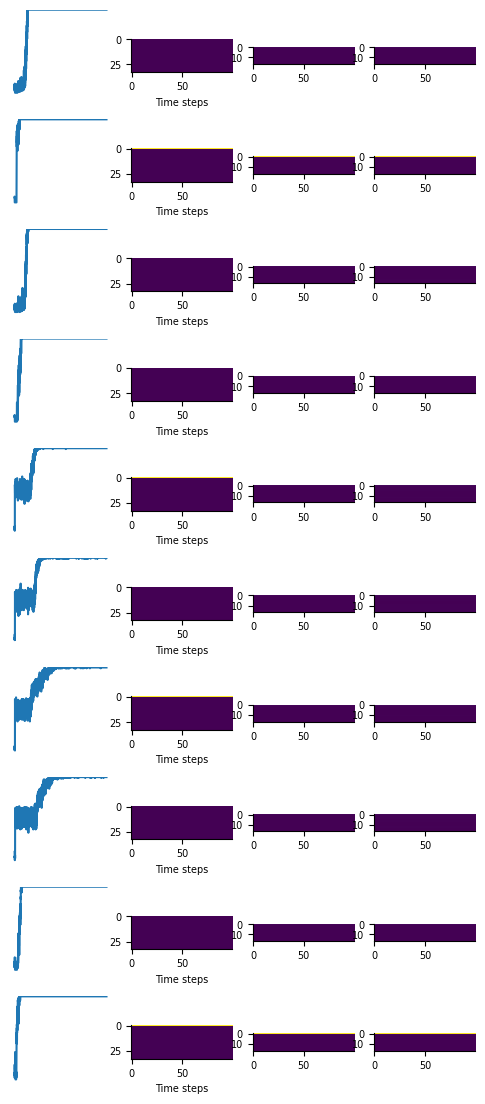

In [22]:
fig, axes = plt.subplots(num_tasks,4, figsize=[6,14])
for logi in range(num_tasks):
    ax = axes[logi , 0 ]
    ax.set_ylim([-0.1,1])
    ax.axis('off')
    log = training_logs[logi]
    ax.plot(log['stamps'], log['accuracy'])
    show_input_output(log['sample_input'], log['sample_label'], log['sample_output'], axes = axes[logi,1:])
plt.show()

In [ ]:
%debug

In [ ]:
plt.close('all')
fig, axes = plt.subplots(20,3, figsize=[6,14])
for i in range(20):
    show_input_output(inputs[i].detach().cpu().numpy().T, labels[i].detach().cpu().numpy().T, outputs[i].detach().cpu().numpy().T, axes=axes[i,:])

plt.show()

In [ ]:
env

In [20]:

def show_input_output(input, label, output=None, axes=None):
    if axes is None:
        fig, axes = plt.subplots(3)
                
    no_output = True if output is None else False
    
    axes[0].imshow(input)
    axes[1].imshow(label)
    if output is not None: axes[2].imshow(output)
    
    axes[0].set_xlabel('Time steps')
#     ax.set_ylabel('fr')
#     ax.set_yticks([1, 17, 33, 34, 49])
    

In [ ]:

        
# save log
# np.save('./files/'+f'{task_pair_id}_log_withMD.npy', log)

# Task performance
label_font = {'family':'Times New Roman','weight':'normal', 'size':15}
title_font = {'family':'Times New Roman','weight':'normal', 'size':20}
legend_font = {'family':'Times New Roman','weight':'normal', 'size':12}
for env_id in range(len(task_pair)):
    plt.figure()
    plt.plot(log['stamps'], log['act_perfs'][env_id])
    plt.fill_between(x=[   0,  20000] , y1=0.0, y2=1.01, facecolor='red', alpha=0.05)
    plt.fill_between(x=[20000, 40000] , y1=0.0, y2=1.01, facecolor='green', alpha=0.05)
    plt.fill_between(x=[40000, 50000], y1=0.0, y2=1.01, facecolor='red', alpha=0.05)
    plt.xlabel('Trials', fontdict=label_font)
    plt.ylabel('Performance', fontdict=label_font)
    plt.title('Task{:d}: '.format(env_id+1)+task_pair[env_id], fontdict=title_font)
    plt.xlim([0.0, None])
    plt.ylim([0.0, 1.01])
    plt.yticks([0.1*i for i in range(11)])
    plt.tight_layout()
    plt.savefig('./files/'+f'{task_pair_id}_performance_withMD_task_{env_id}.png')
    plt.close()


In [ ]:
# set config
config = {
    # envs
     'tasks': ['yang19.dms-v0',
#                'yang19.dnms-v0',
#                'yang19.dmc-v0',
#                'yang19.dnmc-v0',
            #    'yang19.dm1-v0',
            #    'yang19.dm2-v0',
#                'yang19.ctxdm1-v0',
#                'yang19.ctxdm2-v0',
            #    'yang19.multidm-v0',
#                'yang19.dlygo-v0',
#                'yang19.dlyanti-v0',
#                'yang19.go-v0',
            #    'yang19.anti-v0',
               'yang19.rtgo-v0',
               'yang19.rtanti-v0'
               ],
     'trials_per_task' : 50000,
     'batch_size' : 500,
     'print_every_batches': 5000/100,
     'env_kwargs': {'dt': 100},
     'seq_len': 50,
    # model
     'input_size': 33,
     'hidden_size': 256,
     'sub_size': 128,
     'output_size': 17,
     'num_task': 2,
     'MDeffect': False,
     'md_size': 10,
     'md_active_size': 5,
     'md_dt': 0.001,
    # optimizer
     'lr': 1e-4, # 1e-4 for CTRNN, 1e-3 for LSTM
}

task_seq = []
task_sub_seqs = [[(i, config['tasks'][i]) for i in range(s)] for s in range(2, len(config['tasks']))] # interleave tasks and add one task at a time
for sub_seq in task_sub_seqs: task_seq+=sub_seq
print('Task seq to be learned: ', task_seq)

Main loop

In [ ]:
task_seq *= 200


In [ ]:
for task_i, (task_id, task_name) in enumerate(task_seq):
    print (task_i, task_id, task_name)
    

In [ ]:
# model
net = RNN_MD(input_size     = config['input_size'],
             hidden_size    = config['hidden_size'],
             sub_size       = config['sub_size'],
             output_size    = config['output_size'],
             num_task       = config['num_task'],
             dt             = config['env_kwargs']['dt'],
             MDeffect       = config['MDeffect'],
             md_size        = config['md_size'],
             md_active_size = config['md_active_size'],
             md_dt          = config['md_dt'],)
# net = torch.nn.GRU(input_size     = config['input_size'],
#              hidden_size    = config['hidden_size'],)
net = net.to(device)
if config['MDeffect']:
    net.rnn1.md.learn = True
    net.rnn1.md.sendinputs = True
    net.rnn2.md.learn = True
    net.rnn2.md.sendinputs = True
print(net)

# criterion & optimizer
criterion = nn.MSELoss()
print('training parameters:')
training_params = list()
for name, param in net.named_parameters():
    print(name)
    training_params.append(param)
optimizer = torch.optim.Adam(training_params, lr=config['lr'])



overall_loss = []
for task_i, (task_id, task_name) in enumerate(tqdm(task_seq)):

    env = gym.make(task_name, **config['env_kwargs'])
    
    tqdm.write('learning: '+ task_name)

    # training
    running_loss = 0.0
    running_train_time = 0
    log = {
        'task_i': task_i,
        'task_id': task_id,
        'task_name' : task_name,
        'losses': [],
        'stamps': [],
        'accuracy': [[], []],
    }
    bar1 = tqdm(range(config['trials_per_task']//config['batch_size']), desc='batches progress')
    bar2 = trange(config['trials_per_task']//config['batch_size'], desc='batches progress')
    for batch_i in bar2:
    
        # fetch and batch data
        inputs, labels = get_trials_batch(envs=env, batch_size = config['batch_size'])
        # labels shape: [500, 32, 17])
        # inputs shape [batch_size 500, time 32, fixation+ring1+ring2 33])
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, rnn_activity = net(inputs, sub_id=0)
        # viz first and last input-output in a block
#         if (batch_i == 0) or (batch_i== config['trials_per_task']//config['batch_size'] -1):
#             show_input_output(inputs[0], labels[0], outputs[0].detach())
#             plt.show()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # save loss
        log['losses'].append(loss.item())
        bar1.set_description(str(loss.item()))
        running_loss += loss.item()
        # print statistics
#         if batch_i % config['print_every_batches'] ==0:
#             fixation_accuracy, action_accuracy = get_full_performance(env, net)
        
    overall_loss.append(np.array(log['losses']))
overall_loss = np.stack(overall_loss)

In [ ]:
overall_loss_MDtrue = overall_loss.copy()

In [ ]:
plt.plot(overall_loss_MDtrue.reshape([-1]), label = 'MD True') 
# plt.plot(overall_loss_MDfalse.reshape([-1]), label = 'MD False'), plt.legend(['Refresh optimizer every task', 'No optimizer refresh']), plt.show()
plt.show()

In [ ]:
plt.imshow(inputs[0].numpy()), plt.show()

In [ ]:
plt.imshow(labels[0].numpy().T), plt.show()

In [ ]:
torch.cat([inputs[0], labels[0]], 1)

In [ ]:
show_input_output(inputs[0], labels[0], outputs[0].detach().cpu())
plt.show()

In [ ]:
plt.imshow(torch.cat([inputs[0], labels[0]], 1).T)
plt.show()

In [ ]:
np.concatenate(ob, gt.reshape([-1,1]), 0)

In [ ]:
plt.imshow()
plt.show()

In [ ]:
plt.imshow(gt.reshape([1, -1])), plt.show()